In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import torchvision.models as models
import numpy as np
import os
import dlib
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from tqdm.notebook import tqdm
import random
import glob
import pandas as pd
import math
import subprocess
import shutil
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

사용 장치: cuda


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

#데이터셋 다운(CelebA)

In [ ]:
#import kagglehub

#path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

#print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [ ]:
#dlib_model_output_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat"
#dlib_bz2_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat.bz2"

#if not os.path.exists(dlib_model_output_path):
#    print("dlib 모델 파일 다운로드 중...")
#    try:
#        subprocess.run(["wget", "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2", "-O", dlib_bz2_path], check=True)
#        print("다운로드 완료. 압축 해제 중...")
#        subprocess.run(["bzip2", "-d", dlib_bz2_path], check=True)
#        print("압축 해제 완료.")
#    except subprocess.CalledProcessError as e:
#        print(f"명령 실행 오류: {e}")
#        print("dlib 모델 다운로드 또는 압축 해제에 실패했습니다. 인터넷 연결 또는 권한을 확인해주세요.")
#    except FileNotFoundError:
#        print("wget 또는 bzip2 명령을 찾을 수 없습니다. Kaggle 환경에 이 유틸리티가 설치되어 있는지 확인하세요.")
#else:
#    print("dlib 모델 파일이 이미 존재합니다. 다시 다운로드하지 않습니다.")

dlib 모델 파일 다운로드 중...
다운로드 완료. 압축 해제 중...
압축 해제 완료.


#설정

In [ ]:
class Config:
    KAGGLE_CELEBA_ROOT = ""
    DLIB_MODEL_PATH = dlib_model_output_path

    DATA_ROOT = ""
    ORIGINAL_IMAGES_DIR = os.path.join(DATA_ROOT, "original_celeba_aligned")
    MASKED_IMAGES_DIR = os.path.join(DATA_ROOT, "masked_images")
    MASK_MAPS_DIR = os.path.join(DATA_ROOT, "mask_maps")

    NUM_SYNTHETIC_DATA = 10000

    IMG_SIZE = 256
    BATCH_SIZE = 16
    NUM_EPOCHS = 100
    LEARNING_RATE_G = 0.0001
    LEARNING_RATE_D = 0.0001
    BETA1 = 0.5
    BETA2 = 0.999

    LAMBDA_RC = 100.0
    LAMBDA_PERC = 1.0
    LAMBDA_D_WHOLE_REGION = 0.1
    LAMBDA_D_MASK_REGION = 0.1
    LAMBDA_ADV_WHOLE_REGION = 1.0
    LAMBDA_ADV_MASK_REGION = 1.0

    CHECKPOINT_DIR = ""
    LOG_INTERVAL = 50
    SAVE_INTERVAL = 5

    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(ORIGINAL_IMAGES_DIR, exist_ok=True)
    os.makedirs(MASKED_IMAGES_DIR, exist_ok=True)
    os.makedirs(MASK_MAPS_DIR, exist_ok=True)

cfg = Config()

# 데이터 생성

In [ ]:
def align_and_crop_face(image_path, predictor, detector, target_size=256):
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    dets = detector(img_rgb, 1)
    if len(dets) == 0:
        return None, None

    for k, d in enumerate(dets):
        shape = predictor(img_rgb, d)

        left_eye_center = ((shape.part(36).x + shape.part(39).x) // 2, (shape.part(36).y + shape.part(39).y) // 2)
        right_eye_center = ((shape.part(42).x + shape.part(45).x) // 2, (shape.part(42).y + shape.part(45).y) // 2)

        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        face_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                       (left_eye_center[1] + right_eye_center[1]) // 2)

        M = cv2.getRotationMatrix2D(face_center, angle, 1)
        rotated = cv2.warpAffine(img_rgb, M, (img_rgb.shape[1], img_rgb.shape[0]), flags=cv2.INTER_CUBIC)

        x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()

        width = x2 - x1
        height = y2 - y1
        max_dim = max(width, height)

        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        start_x = max(0, center_x - max_dim // 2)
        start_y = max(0, center_y - max_dim // 2)
        end_x = min(rotated.shape[1], center_x + max_dim // 2)
        end_y = min(rotated.shape[0], center_y + max_dim // 2)

        cropped_face = rotated[start_y:end_y, start_x:end_x]

        if cropped_face.shape[0] == 0 or cropped_face.shape[1] == 0:
            return None, None

        aligned_face = cv2.resize(cropped_face, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return Image.fromarray(aligned_face), d

def add_simple_mask(face_img_pil, dlib_rect, target_size=256):
    face_img_np = np.array(face_img_pil.convert("RGB"))
    masked_img_pil = face_img_pil.copy()

    mask_map_pil = Image.new('L', (target_size, target_size), 0)
    draw_masked_img = ImageDraw.Draw(masked_img_pil)
    draw_mask_map = ImageDraw.Draw(mask_map_pil)

    mask_type = random.choice(['rectangle', 'oval'])
    mask_color = (0, 0, 0)
    mask_map_color = 255

    if mask_type == 'rectangle':
        mask_width = int(target_size * random.uniform(0.5, 0.7))
        mask_height = int(target_size * random.uniform(0.2, 0.35))

        x1 = (target_size - mask_width) // 2
        y1 = int(target_size * random.uniform(0.5, 0.65))
        x2 = x1 + mask_width
        y2 = y1 + mask_height

        draw_masked_img.rectangle([x1, y1, x2, y2], fill=mask_color)
        draw_mask_map.rectangle([x1, y1, x2, y2], fill=mask_map_color)

    elif mask_type == 'oval':
        mask_width = int(target_size * random.uniform(0.55, 0.75))
        mask_height = int(target_size * random.uniform(0.3, 0.45))

        x1 = (target_size - mask_width) // 2
        y1 = int(target_size * random.uniform(0.45, 0.6))
        x2 = x1 + mask_width
        y2 = y1 + mask_height

        draw_masked_img.ellipse([x1, y1, x2, y2], fill=mask_color)
        draw_mask_map.ellipse([x1, y1, x2, y2], fill=mask_map_color)

    return masked_img_pil, mask_map_pil

def generate_synthetic_data(cfg):
    print("합성 데이터 생성 시작...")

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(cfg.DLIB_MODEL_PATH)

    celeba_img_dir = os.path.join(cfg.KAGGLE_CELEBA_ROOT, "img_align_celeba", "img_align_celeba")
    all_celeba_images = sorted(glob.glob(os.path.join(celeba_img_dir, "*.jpg")))

    if cfg.NUM_SYNTHETIC_DATA > len(all_celeba_images):
        print(f"경고: 요청된 데이터 수 ({cfg.NUM_SYNTHETIC_DATA})가 CelebA 이미지 수({len(all_celeba_images)})보다 많습니다. 가능한 모든 이미지를 사용합니다.")
        selected_images = all_celeba_images
    else:
        selected_images = random.sample(all_celeba_images, cfg.NUM_SYNTHETIC_DATA)

    processed_count = 0
    for i, img_path in enumerate(tqdm(selected_images, desc="데이터 생성 중")):
        try:
            original_pil, dlib_rect = align_and_crop_face(img_path, predictor, detector, cfg.IMG_SIZE)
            if original_pil is None:
                continue

            masked_pil, mask_map_pil = add_simple_mask(original_pil, dlib_rect, cfg.IMG_SIZE)

            if masked_pil is None or mask_map_pil is None:
                continue

            file_name_stem = f"{processed_count:06d}.jpg"
            mask_map_file_name_stem = f"{processed_count:06d}.png"

            original_pil.save(os.path.join(cfg.ORIGINAL_IMAGES_DIR, file_name_stem))
            masked_pil.save(os.path.join(cfg.MASKED_IMAGES_DIR, file_name_stem))
            mask_map_pil.save(os.path.join(cfg.MASK_MAPS_DIR, mask_map_file_name_stem))

            processed_count += 1
            if processed_count >= cfg.NUM_SYNTHETIC_DATA:
                break

        except Exception as e:
            print(f"이미지 처리 중 오류 발생 {img_path}: {e}")
            continue

    print(f"합성 데이터 생성 완료. 총 {processed_count}개의 샘플이 생성되었습니다.")

if os.path.exists(cfg.DATA_ROOT):
    shutil.rmtree(cfg.DATA_ROOT)
    os.makedirs(cfg.ORIGINAL_IMAGES_DIR, exist_ok=True)
    os.makedirs(cfg.MASKED_IMAGES_DIR, exist_ok=True)
    os.makedirs(cfg.MASK_MAPS_DIR, exist_ok=True)

generate_synthetic_data(cfg)


합성 데이터 생성 시작...


데이터 생성 중:   0%|          | 0/10000 [00:00<?, ?it/s]

합성 데이터 생성 완료. 총 9720개의 샘플이 생성되었습니다.


#데이터셋 및 DataLoader

In [ ]:
class MaskedFaceDataset(Dataset):
    def __init__(self, cfg, transform=None):
        self.cfg = cfg
        self.transform = transform
        self.original_images = sorted(glob.glob(os.path.join(cfg.ORIGINAL_IMAGES_DIR, "*.jpg")))
        self.masked_images = sorted(glob.glob(os.path.join(cfg.MASKED_IMAGES_DIR, "*.jpg")))
        self.mask_maps = sorted(glob.glob(os.path.join(cfg.MASK_MAPS_DIR, "*.png")))

        assert len(self.original_images) == len(self.masked_images) == len(self.mask_maps), \
            "데이터셋의 이미지 파일 수가 일치하지 않습니다!"
        self.num_samples = len(self.original_images)
        print(f"로드할 데이터셋 샘플 수: {self.num_samples}")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        orig_img_path = self.original_images[idx]
        masked_img_path = self.masked_images[idx]
        mask_map_path = self.mask_maps[idx]

        I_gt = Image.open(orig_img_path).convert("RGB")
        I_input = Image.open(masked_img_path).convert("RGB")
        I_mask_map = Image.open(mask_map_path).convert("L")

        if self.transform:
            I_gt = self.transform(I_gt)
            I_input = self.transform(I_input)
            I_mask_map = transforms.ToTensor()(I_mask_map)
            I_mask_map = (I_mask_map > 0.5).float()

        return I_input, I_mask_map, I_gt

transform_img = transforms.Compose([
    transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = MaskedFaceDataset(cfg, transform=transform_img)
dataloader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

print(f"DataLoader 배치 수: {len(dataloader)}")

로드할 데이터셋 샘플 수: 9720
DataLoader 배치 수: 608


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class G_edit(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, features=64):
        super(G_edit, self).__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.down1 = self._down_block(features, features * 2)
        self.down2 = self._down_block(features * 2, features * 4)
        self.down3 = self._down_block(features * 4, features * 8)
        self.down4 = self._down_block(features * 8, features * 8)
        self.down5 = self._down_block(features * 8, features * 8)
        self.down6 = self._down_block(features * 8, features * 8)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True)
        )

        self.up1 = self._up_block(features * 8, features * 8)
        self.up2 = self._up_block(features * 8 * 2, features * 8)
        self.up3 = self._up_block(features * 8 * 2, features * 8)
        self.up4 = self._up_block(features * 8 * 2, features * 4)

        self.up5 = self._up_block(features * 4 + features * 8, features * 2)

        self.up6 = self._up_block(features * 2 + features * 4, features)

        self.up7 = self._up_block(features + features * 2, features)

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1, bias=False),
        )

    def _down_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        d1 = self.initial_down(x)

        d2 = self.down1(d1)

        d3 = self.down2(d2)

        d4 = self.down3(d3)

        d5 = self.down4(d4)

        d6 = self.down5(d5)

        d7 = self.down6(d6)


        b = self.bottleneck(d7)


        u1 = self.up1(b)
        u1_cat = torch.cat([u1, d7], 1)

        u2 = self.up2(u1_cat)
        u2_cat = torch.cat([u2, d6], 1)

        u3 = self.up3(u2_cat)
        u3_cat = torch.cat([u3, d5], 1)

        u4 = self.up4(u3_cat)
        u4_cat = torch.cat([u4, d4], 1)

        u5 = self.up5(u4_cat)
        u5_cat = torch.cat([u5, d3], 1)

        u6 = self.up6(u5_cat)
        u6_cat = torch.cat([u6, d2], 1)

        u7 = self.up7(u6_cat)
        u7_cat = torch.cat([u7, d1], 1)

        return self.final_up(u7_cat)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            self._block(features, features * 2, 4, 2, 1),
            self._block(features * 2, features * 4, 4, 2, 1),
            self._block(features * 4, features * 8, 4, 1, 1),

            nn.Conv2d(features * 8, 1, 4, 1, 1, bias=False)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

netG = G_edit().to(device)
netD_whole = Discriminator().to(device)
netD_mask = Discriminator().to(device)

netG.apply(weights_init)
netD_whole.apply(weights_init)
netD_mask.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kerne

In [ ]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, requires_grad=False):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        self.slice5 = nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg[x])

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X, Y):
        X = (X + 1) / 2
        Y = (Y + 1) / 2
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        X = normalize(X)
        Y = normalize(Y)

        h_X_1 = self.slice1(X)
        h_Y_1 = self.slice1(Y)
        h_X_2 = self.slice2(h_X_1)
        h_Y_2 = self.slice2(h_Y_1)
        h_X_3 = self.slice3(h_X_2)
        h_Y_3 = self.slice3(h_Y_2)
        h_X_4 = self.slice4(h_X_3)
        h_Y_4 = self.slice4(h_Y_3)
        h_X_5 = self.slice5(h_X_4)
        h_Y_5 = self.slice5(h_Y_4)

        loss = sum([
            torch.mean(torch.abs(h_X_1 - h_Y_1)),
            torch.mean(torch.abs(h_X_2 - h_Y_2)),
            torch.mean(torch.abs(h_X_3 - h_Y_3)),
            torch.mean(torch.abs(h_X_4 - h_Y_4)),
            torch.mean(torch.abs(h_X_5 - h_Y_5))
        ])
        return loss

criterion_L1 = nn.L1Loss().to(device)
criterion_bce_logits = nn.BCEWithLogitsLoss().to(device)

perc_loss_fn = VGGPerceptualLoss().to(device)

def ssim_loss_fn(img1, img2, device):
    img1_np = ((img1.detach().cpu().numpy() + 1) / 2).transpose(0, 2, 3, 1)
    img2_np = ((img2.detach().cpu().numpy() + 1) / 2).transpose(0, 2, 3, 1)

    loss = 0.0
    for i in range(img1_np.shape[0]):

        score = ssim(img1_np[i], img2_np[i], data_range=1.0, win_size=7, channel_axis=-1)
        loss += (1 - score)
    return torch.tensor(loss / img1_np.shape[0], device=device)

optimizer_G = optim.Adam(netG.parameters(), lr=cfg.LEARNING_RATE_G, betas=(cfg.BETA1, cfg.BETA2))
optimizer_D_whole = optim.Adam(netD_whole.parameters(), lr=cfg.LEARNING_RATE_D, betas=(cfg.BETA1, cfg.BETA2))
optimizer_D_mask = optim.Adam(netD_mask.parameters(), lr=cfg.LEARNING_RATE_D, betas=(cfg.BETA1, cfg.BETA2))

#체크포인트

In [ ]:
start_epoch = 80

latest_checkpoint_list = sorted(glob.glob(os.path.join(cfg.CHECKPOINT_DIR, "*.pth")))

if latest_checkpoint_list:
    latest_checkpoint = latest_checkpoint_list[-1]
    print(f"가장 최신 체크포인트: {latest_checkpoint} 로드 중...")

    checkpoint = torch.load(latest_checkpoint, map_location=device)

    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD_whole.load_state_dict(checkpoint['netD_whole_state_dict'])
    netD_mask.load_state_dict(checkpoint['netD_mask_state_dict'])

    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_whole.load_state_dict(checkpoint['optimizer_D_whole_state_dict'])
    optimizer_D_mask.load_state_dict(checkpoint['optimizer_D_mask_state_dict'])

    start_epoch = checkpoint['epoch'] + 1

    print(f"모델 및 옵티마이저 로드 완료. 훈련을 {start_epoch} 에폭부터 재개합니다.")
else:
    print("훈련된 체크포인트가 없습니다. 처음부터 훈련을 시작합니다.")

가장 최신 체크포인트: /content/drive/MyDrive/unmasking_checkpoint/unmasking_gan_epoch_80.pth 로드 중...
모델 및 옵티마이저 로드 완료. 훈련을 80 에폭부터 재개합니다.


#훈련 루프

In [ ]:
real_label = 1.0
fake_label = 0.0

for epoch in range(start_epoch, cfg.NUM_EPOCHS):
    netG.train()
    netD_whole.train()
    netD_mask.train()

    loop = tqdm(dataloader, leave=True)
    for batch_idx, (I_input, I_mask_map, I_gt) in enumerate(loop):
        I_input = I_input.to(device)
        I_mask_map = I_mask_map.to(device)
        I_gt = I_gt.to(device)

        batch_size = I_input.shape[0]

        netD_whole.zero_grad()
        output_D_whole_real = netD_whole(I_gt)
        errD_whole_real = criterion_bce_logits(output_D_whole_real, torch.full_like(output_D_whole_real, real_label, device=device))
        errD_whole_real.backward()

        I_edit = netG(torch.cat([I_input, I_mask_map], dim=1))
        output_D_whole_fake = netD_whole(I_edit.detach())
        errD_whole_fake = criterion_bce_logits(output_D_whole_fake, torch.full_like(output_D_whole_fake, fake_label, device=device))
        errD_whole_fake.backward()

        errD_whole = errD_whole_real + errD_whole_fake
        optimizer_D_whole.step()

        netD_mask.zero_grad()
        I_mask_region_gt = I_input * (1 - I_mask_map) + I_gt * I_mask_map
        I_mask_region_edit = I_input * (1 - I_mask_map) + I_edit.detach() * I_mask_map

        output_D_mask_real = netD_mask(I_mask_region_gt)
        errD_mask_real = criterion_bce_logits(output_D_mask_real, torch.full_like(output_D_mask_real, real_label, device=device))
        errD_mask_real.backward()

        output_D_mask_fake = netD_mask(I_mask_region_edit)
        errD_mask_fake = criterion_bce_logits(output_D_mask_fake, torch.full_like(output_D_mask_fake, fake_label, device=device))
        errD_mask_fake.backward()

        errD_mask = errD_mask_real + errD_mask_fake
        optimizer_D_mask.step()

        netG.zero_grad()

        loss_L1 = criterion_L1(I_edit, I_gt)
        loss_ssim = ssim_loss_fn(I_edit, I_gt, device)
        loss_rc = loss_L1 + loss_ssim

        loss_perc = perc_loss_fn(I_edit, I_gt)

        output_G_whole = netD_whole(I_edit)
        loss_adv_whole_region = criterion_bce_logits(output_G_whole, torch.full_like(output_G_whole, real_label, device=device))

        I_mask_region_edit_for_G = I_input * (1 - I_mask_map) + I_edit * I_mask_map
        output_G_mask = netD_mask(I_mask_region_edit_for_G)
        loss_adv_mask_region = criterion_bce_logits(output_G_mask, torch.full_like(output_G_mask, real_label, device=device))

        errG = cfg.LAMBDA_RC * (loss_rc + cfg.LAMBDA_PERC * loss_perc) + \
               cfg.LAMBDA_ADV_WHOLE_REGION * loss_adv_whole_region + \
               cfg.LAMBDA_ADV_MASK_REGION * loss_adv_mask_region

        errG.backward()
        optimizer_G.step()

        if (batch_idx + 1) % cfg.LOG_INTERVAL == 0:
            loop.set_description(f"Epoch [{epoch+1}/{cfg.NUM_EPOCHS}]")
            loop.set_postfix(
                Loss_D_whole=errD_whole.item(),
                Loss_D_mask=errD_mask.item(),
                Loss_G=errG.item(),
                Loss_L1=loss_L1.item(),
                Loss_SSIM=loss_ssim.item(),
                Loss_Perc=loss_perc.item()
            )

    if (epoch + 1) % cfg.SAVE_INTERVAL == 0:
        if not os.path.exists(cfg.CHECKPOINT_DIR):
            os.makedirs(cfg.CHECKPOINT_DIR)

        checkpoint_path = os.path.join(cfg.CHECKPOINT_DIR, f"unmasking_gan_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_whole_state_dict': netD_whole.state_dict(),
            'netD_mask_state_dict': netD_mask.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_whole_state_dict': optimizer_D_whole.state_dict(),
            'optimizer_D_mask_state_dict': optimizer_D_mask.state_dict(),
            'loss_G': errG.item(),
            'loss_D_whole': errD_whole.item(),
            'loss_D_mask': errD_mask.item(),
        }, checkpoint_path)
        print(f"체크포인트 저장됨: {checkpoint_path}")

print("훈련 완료!")

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

체크포인트 저장됨: /content/drive/MyDrive/unmasking_checkpoint/unmasking_gan_epoch_85.pth


  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

체크포인트 저장됨: /content/drive/MyDrive/unmasking_checkpoint/unmasking_gan_epoch_90.pth


  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

체크포인트 저장됨: /content/drive/MyDrive/unmasking_checkpoint/unmasking_gan_epoch_95.pth


  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

체크포인트 저장됨: /content/drive/MyDrive/unmasking_checkpoint/unmasking_gan_epoch_100.pth
훈련 완료!


가장 최신 체크포인트: /content/drive/MyDrive/unmasking_checkpoint/unmasking_gan_epoch_95.pth 로드 중...


모델 로드 완료 및 평가 준비됨.

총 5개 이미지에 대한 마스크 제거 및 평가 시작...

--- 테스트 이미지 1/5 (파일명: 000000.jpg) ---
  PSNR: 35.5185
  SSIM: 0.9667
  Perceptual Loss (FD): 0.4126


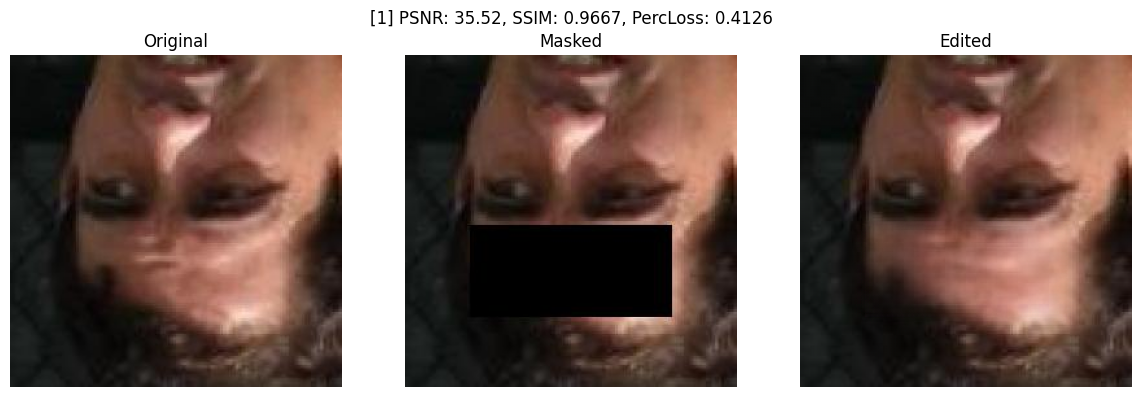


--- 테스트 이미지 2/5 (파일명: 000001.jpg) ---
  PSNR: 37.6825
  SSIM: 0.9687
  Perceptual Loss (FD): 0.4400


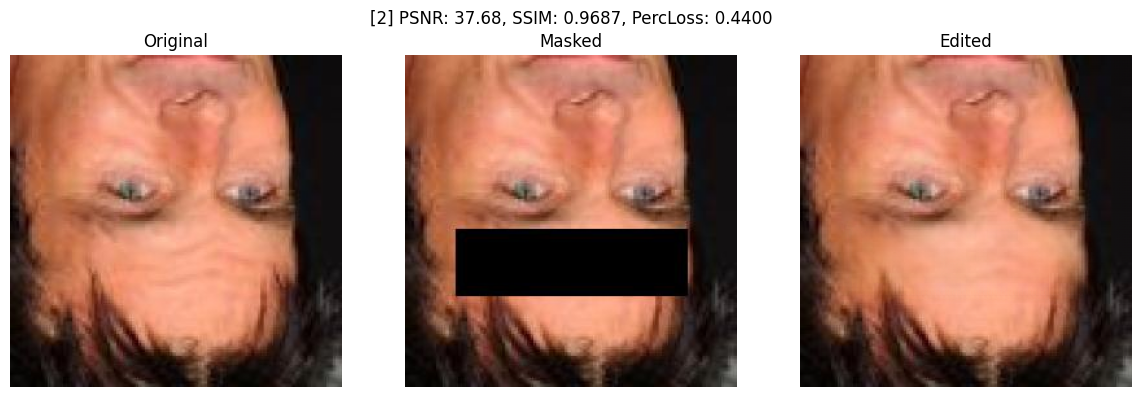


--- 테스트 이미지 3/5 (파일명: 000002.jpg) ---
  PSNR: 32.4642
  SSIM: 0.9290
  Perceptual Loss (FD): 0.5458


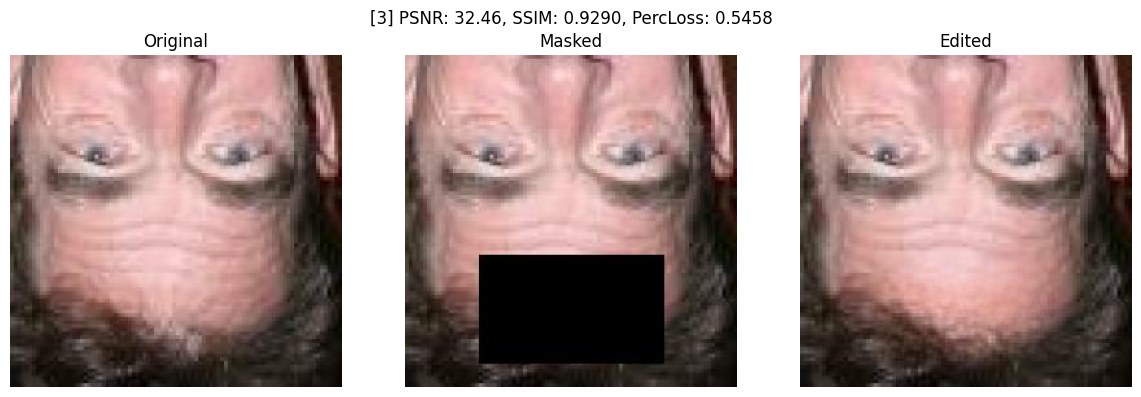


--- 테스트 이미지 4/5 (파일명: 000003.jpg) ---
  PSNR: 36.5734
  SSIM: 0.9750
  Perceptual Loss (FD): 0.3728


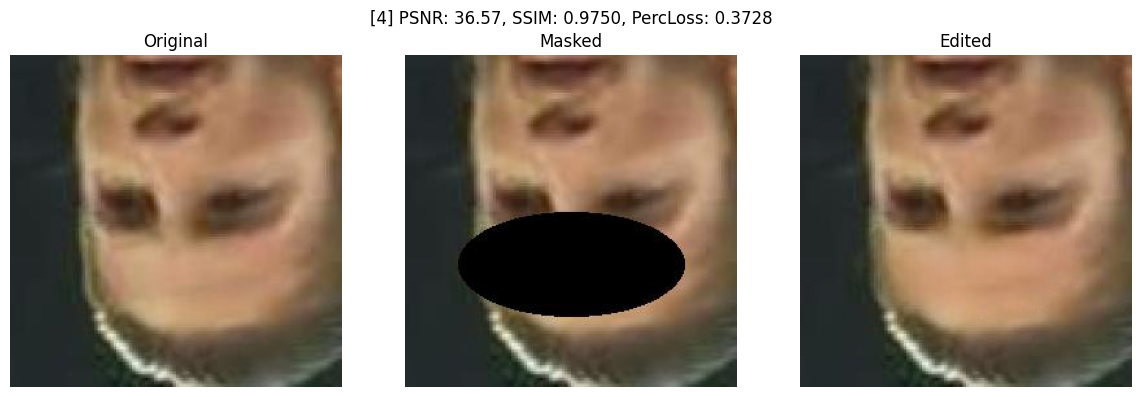


--- 테스트 이미지 5/5 (파일명: 000004.jpg) ---
  PSNR: 35.9506
  SSIM: 0.9660
  Perceptual Loss (FD): 0.4041


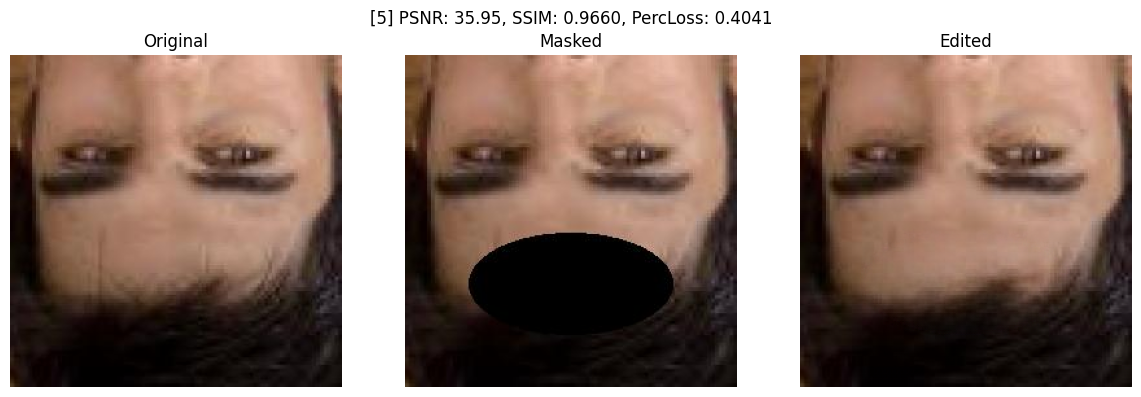


=== 5개 이미지에 대한 평균 평가 결과 ===
평균 PSNR: 35.6378
평균 SSIM: 0.9611
평균 Perceptual Loss (FD): 0.4351
------------------------------------------

모든 테스트 완료!


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def show_images(original, masked, edited, idx, psnr, ssim_val, perc_loss):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title('Original')
    axs[1].imshow(masked)
    axs[1].set_title('Masked')
    axs[2].imshow(edited)
    axs[2].set_title('Edited')
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f"[{idx+1}] PSNR: {psnr:.2f}, SSIM: {ssim_val:.4f}, PercLoss: {perc_loss:.4f}")
    plt.tight_layout()
    plt.show()

def unmask_image(net_g_model, masked_img_path, mask_map_path):
    net_g_model.eval()

    input_img_pil = Image.open(masked_img_path).convert("RGB")
    mask_map_pil = Image.open(mask_map_path).convert("L")

    input_tensor = test_transform(input_img_pil).unsqueeze(0).to(device)
    mask_map_tensor = transforms.ToTensor()(mask_map_pil).unsqueeze(0).to(device)
    mask_map_tensor = (mask_map_tensor > 0.5).float()

    with torch.no_grad():
        gen_input = torch.cat([input_tensor, mask_map_tensor], dim=1)
        edited_img_tensor = net_g_model(gen_input)

    return edited_img_tensor, input_tensor

latest_checkpoint_list = sorted(glob.glob(os.path.join(cfg.CHECKPOINT_DIR, "*.pth")))

if latest_checkpoint_list:
    latest_checkpoint = latest_checkpoint_list[-1]
    print(f"가장 최신 체크포인트: {latest_checkpoint} 로드 중...")

    netG.load_state_dict(torch.load(latest_checkpoint)['netG_state_dict'])
    netG.eval()
    print(f"모델 로드 완료 및 평가 준비됨.")

    if dataset.num_samples > 0:
        num_samples_to_test = min(5, dataset.num_samples)
        print(f"\n총 {num_samples_to_test}개 이미지에 대한 마스크 제거 및 평가 시작...")

        total_psnr = 0.0
        total_ssim = 0.0
        total_perc = 0.0

        for i in range(num_samples_to_test):
          masked_img_path = dataset.masked_images[i]
          mask_map_path = dataset.mask_maps[i]
          original_img_path = dataset.original_images[i]

          print(f"\n--- 테스트 이미지 {i+1}/{num_samples_to_test} (파일명: {os.path.basename(masked_img_path)}) ---")


          edited_img_tensor, _ = unmask_image(netG, masked_img_path, mask_map_path)


          I_gt_pil = Image.open(original_img_path).convert("RGB")
          I_gt_tensor = test_transform(I_gt_pil).unsqueeze(0).to(device)


          I_edit_np = ((edited_img_tensor.detach().cpu().squeeze(0).numpy() + 1) / 2).transpose(1, 2, 0)
          I_gt_np = ((I_gt_tensor.detach().cpu().squeeze(0).numpy() + 1) / 2).transpose(1, 2, 0)


          current_psnr = psnr_metric(I_gt_np, I_edit_np, data_range=1.0)
          total_psnr += current_psnr

          current_ssim = ssim(I_gt_np, I_edit_np, data_range=1.0, channel_axis=-1)
          total_ssim += current_ssim

          current_perc_loss = perc_loss_fn(edited_img_tensor, I_gt_tensor).item()
          total_perc += current_perc_loss

          print(f"  PSNR: {current_psnr:.4f}")
          print(f"  SSIM: {current_ssim:.4f}")
          print(f"  Perceptual Loss (FD): {current_perc_loss:.4f}")


          I_masked_pil = Image.open(masked_img_path).convert("RGB").resize((cfg.IMG_SIZE, cfg.IMG_SIZE))
          I_masked_np = np.asarray(I_masked_pil).astype(np.float32) / 255.0

          show_images(I_gt_np, I_masked_np, I_edit_np,
                      idx=i, psnr=current_psnr, ssim_val=current_ssim, perc_loss=current_perc_loss)


        avg_psnr = total_psnr / num_samples_to_test
        avg_ssim = total_ssim / num_samples_to_test
        avg_perc = total_perc / num_samples_to_test

        print(f"\n=== {num_samples_to_test}개 이미지에 대한 평균 평가 결과 ===")
        print(f"평균 PSNR: {avg_psnr:.4f}")
        print(f"평균 SSIM: {avg_ssim:.4f}")
        print(f"평균 Perceptual Loss (FD): {avg_perc:.4f}")
        print("------------------------------------------")

    else:
        print("생성된 데이터 샘플이 없어 테스트를 수행할 수 없습니다.")
else:
    print("훈련된 체크포인트가 없습니다. 먼저 훈련을 실행하세요.")

print("\n모든 테스트 완료!")